<a href="https://colab.research.google.com/github/faizankhan29/Deep_Learning_for_NLP/blob/master/Classification%20of%20text%20using%20CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of text using CNNs.

In this repository, I am performing a basic classification of tweets into relevant and non-relevant.

Reference:https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb

## Importing libraries and data

In [0]:
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs

In [0]:
#input_file=pd.read_csv("socialmedia-disaster-tweets-DFE.csv",encoding='utf-8',errors='replace')

input_file = codecs.open("socialmedia-disaster-tweets-DFE.csv", "r",encoding='utf-8', errors='replace')
output_file = open("socialmedia_relevant_cols_clean.csv", "w")

def sanitize_characters(raw, clean):    
    for line in input_file:
        out = line
        output_file.write(line)
sanitize_characters(input_file, output_file)

In [27]:
questions = pd.read_csv("socialmedia_relevant_cols_clean.csv")
#rint(questions.head())
questions=questions[['text','choose_one']]
questions.head()


,text,choose_one
0,Just happened a terrible car crash,Relevant
1,Our Deeds are the Reason of this #earthquake M...,Relevant
2,"Heard about #earthquake is different cities, s...",Relevant
3,"there is a forest fire at spot pond, geese are...",Relevant
4,Forest fire near La Ronge Sask. Canada,Relevant


## Cleaning the data

Here, we remove all urls and special characters from the text and tokenize.

In [0]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

clean_questions = standardize_text(questions, "text")


In [29]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)
clean_questions.head()

,text,choose_one,tokens
0,just happened a terrible car crash,Relevant,"[just, happened, a, terrible, car, crash]"
1,our deeds are the reason of this earthquake m...,Relevant,"[our, deeds, are, the, reason, of, this, earth..."
2,"heard about earthquake is different cities, s...",Relevant,"[heard, about, earthquake, is, different, citi..."
3,"there is a forest fire at spot pond, geese are...",Relevant,"[there, is, a, forest, fire, at, spot, pond, g..."
4,forest fire near la ronge sask canada,Relevant,"[forest, fire, near, la, ronge, sask, canada]"


In [30]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

154618 words total, with a vocabulary size of 18096
Max sentence length is 34


## Understanding sentence lengths.

Here,we plot lengths of tweets to understand the distribution.

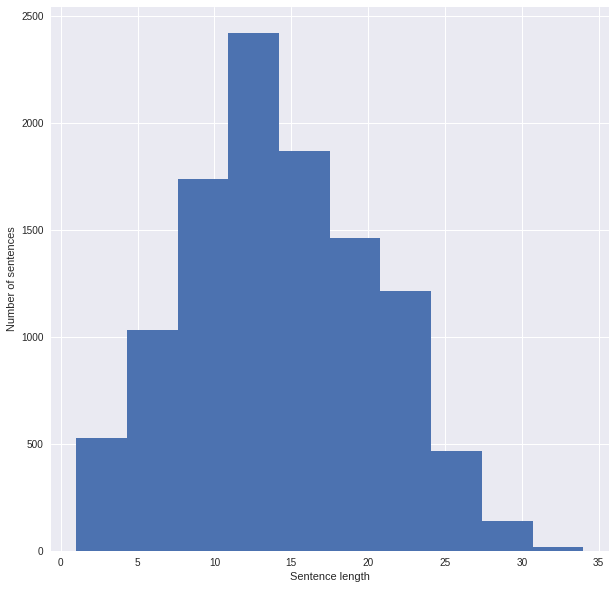

In [31]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

Converting output classes to numbers

In [0]:
def convert_to_num(x):
  if x=='Relevant':
    return 1
  else:
    return 0

In [0]:
clean_questions['class_label']=clean_questions['choose_one'].apply(lambda x:convert_to_num(x))

Loading pre-trained Google word vectors.

In [0]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'

##Preparing the Data for classification.

Here, we are preparing the data for classification by padding and getting the relevant word vectors.

In [0]:
import gensim
word2vec = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDING_FILE,unicode_errors='ignore',binary=True)

In [34]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 35
VOCAB_SIZE = len(VOCAB)

VALIDATION_SPLIT=.2
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(clean_questions["text"].tolist())
print(tokenizer)
sequences = tokenizer.texts_to_sequences(clean_questions["text"].tolist())
print(sequences)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print(cnn_data[0:10])
labels = to_categorical(np.asarray(clean_questions["class_label"]))

indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

[[28, 776, 2, 1505, 126, 95], [109, 5734, 20, 1, 841, 5, 18, 249, 150, 1801, 3739, 85, 37], [375, 50, 249, 8, 1302, 1802, 647, 1506, 265], [74, 8, 2, 166, 40, 15, 817, 2502, 8295, 20, 4468, 889, 1, 682, 7, 1367, 486, 96, 37], [166, 40, 204, 918, 8296, 8297, 1432], [37, 1593, 1507, 3, 8298, 4, 5735, 20, 140, 8299, 17, 1803, 35, 277, 270, 53, 2255, 4, 777, 1695, 20, 1254], [818, 2795, 59, 4469, 1368, 270, 1695, 4, 111], [28, 99, 1508, 18, 290, 19, 5736, 2503, 26, 278, 19, 1368, 8300, 68, 2, 205], [3189, 412, 111, 1940, 842, 890, 4, 801, 8301, 413, 3, 1255, 414, 40, 5737, 1368], [383, 3190, 5738, 1368], [206, 73, 891, 297, 1107, 892, 298, 5, 1804, 4, 8302, 1108, 2796, 1594], [220, 778, 342, 2504, 4, 683, 6, 1256], [819, 3740, 62, 42, 249], [44, 10, 221, 5, 1, 2093, 6, 7, 67, 106, 2, 40, 4, 1, 4470], [514, 42, 72, 270, 1257, 51, 4, 1, 578, 889, 1, 682], [44, 2256, 16, 1, 592, 8, 250, 3, 109, 312], [487, 59, 537, 19, 1, 266, 415, 32, 579], [919, 559, 2797, 8, 241, 2798, 4471, 684, 2, 710, 7

##Defining the ConvNet Architecture

Here, we will define the architecture for the ConvNet used for classification

In [0]:
from keras.layers import Dense, Input, Flatten, Dropout,concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model

def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    #l_merge = Merge(mode='concat', concat_axis=1)(convs)
    l_merge = concatenate(convs,axis=1)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)

    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

##Testing the results
We will be testing our results here.

In [0]:
x_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = cnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM, 
                len(list(clean_questions["class_label"].unique())), False)

In [42]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, batch_size=128)

Train on 8696 samples, validate on 2173 samples
Epoch 1/3
8696/8696 [==============================] - 18s 2ms/step - loss: 0.5980 - acc: 0.6870 - val_loss: 0.4673 - val_acc: 0.7879
Epoch 2/3
8696/8696 [==============================] - 18s 2ms/step - loss: 0.4527 - acc: 0.7955 - val_loss: 0.4487 - val_acc: 0.7911
Epoch 3/3
8696/8696 [==============================] - 18s 2ms/step - loss: 0.4054 - acc: 0.8197 - val_loss: 0.4527 - val_acc: 0.7892
